# Topic Modelling


### Set up environment

In [1]:
import os
import json
import re
import html
import string
import contractions
from PIL import Image
import numpy as np
import spacy
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download(['wordnet', 'punkt', 'stopwords', 'omw-1.4'])
# ! python -m spacy download en_core_web_sm     # Only run this if you don't have the spacy model installed

[nltk_data] Downloading package wordnet to
[nltk_data]     /local/home/p11333at/.cache...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /local/home/p11333at/.cache...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /local/home/p11333at/.cache...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /local/home/p11333at/.cache...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Data Preparation

In [2]:
stop_words = set(stopwords.words('english'))
punctuations = string.punctuation
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

slang_path = "../data/slang.json"
with open(slang_path, "r") as f:
    slang_dicts = json.load(f)
    for slang in slang_dicts:
        contractions.add(slang, slang_dicts[slang])

In [3]:
def load_single_file(file_path):
    with open(file_path, 'r') as f:
        data = f.readlines()
    corpus = [json.loads(line)['content'] for line in data]
    return corpus

def load_files(folder_path):
    files = os.listdir(folder_path)
    corpus = []
    for filename in files:
        file_path = os.path.join(folder_path, filename)
        with open(file_path) as f:
            data = f.readlines()
            data_json = [json.loads(line)['content'] for line in data]
            corpus.extend(data_json)
    return corpus
    
def preprocess(document):
    document = html.unescape(document)

    re_alias = r"(?:USERNAME|URL)_\d*\s*"
    pattern = re_alias
    anonymous_document = re.sub(pattern, "", document)
    result = []

    removal = []  # ["covid", "pandemic"]
    for token in simple_preprocess(anonymous_document):
        if token not in STOPWORDS and token not in removal:
            lemma = lemmatizer.lemmatize(token)################
            result.append(lemma)
    return result

def nltk_preprocess(document):
    # Decode string which includes special characters
    document = html.unescape(document)
    document = contractions.fix(document)

    # Remove
    re_alias = r"(?:USERNAME|URL)_\d*\s*"   # Remove aliases of USERNAME and URL
    re_number = r"\d+"                      # Remove numbers
    re_punctuation = r"[^\w\s]"             # Remove punctuation
    pattern = f"({re_alias})|({re_number})|({re_punctuation})"
    cleaned_document = re.sub(pattern, "", document)
    
    tokens = word_tokenize(cleaned_document.lower())
    result = []
    for token in tokens:
        if token not in stop_words and token:
            lemmas = lemmatizer.lemmatize(token)
            result.append(lemmas)

    return result

def spacy_preprocess(document):
    # Decode string which includes special characters
    document = html.unescape(document)
    document = contractions.fix(document)

    # Remove
    re_alias = r"(?:USERNAME|URL)_\d*\s*"   # Remove aliases of USERNAME and URL
    re_number = r"\d+"                      # Remove numbers
    re_punctuation = r"[^\w\s]"             # Remove punctuation
    pattern = f"({re_alias})|({re_number})|({re_punctuation})"
    cleaned_document = re.sub(pattern, "", document)
    
    doc = nlp(cleaned_document.lower())
    result = []
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and not token.like_num:
            result.append(token.lemma_)

    return result

### Loading Local Datasets

In [5]:
# Load data
folder_path = '../data/raw/'
filename = 'tweets_230227_#63481.json'
# corpus = load_single_file(folder_path+filename)
corpus = load_files(folder_path)

### Pre-processing

In [ ]:
# create a list of preprocessed documents
# processed_docs = [preprocess(doc) for doc in corpus]
# processed_docs = [spacy_preprocess(doc) for doc in corpus]
processed_docs = [nltk_preprocess(doc) for doc in corpus]

# create a dictionary from the preprocessed documents
dictionary = corpora.Dictionary(processed_docs)

# create a document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in processed_docs]


### Train LDA model

In [ ]:
# define the number of topics
num_topics = 5

# create the LDA model
lda_model = models.LdaModel(
    corpus=doc_term_matrix,
    num_topics=num_topics,
    random_state=0,
    chunksize=100,
    alpha='auto',
    per_word_topics=True,
    id2word=dictionary,
)


In [ ]:
# print the topics and the top words
for idx, topic in lda_model.print_topics(num_words=10):
    print("Topic: {} \nWords: {}".format(idx, topic))


Topic: 0 
Words: 0.038*"shout" + 0.036*"significant" + 0.030*"like" + 0.028*"united" + 0.027*"states" + 0.016*"long" + 0.015*"day" + 0.012*"world" + 0.011*"test" + 0.008*"pay"
Topic: 1 
Words: 0.064*"high" + 0.060*"end" + 0.055*"vaccine" + 0.053*"happy" + 0.051*"explosive" + 0.023*"new" + 0.023*"trump" + 0.021*"china" + 0.015*"news" + 0.014*"government"
Topic: 2 
Words: 0.032*"think" + 0.024*"lie" + 0.021*"note" + 0.020*"author" + 0.015*"work" + 0.014*"mask" + 0.012*"right" + 0.012*"virus" + 0.011*"health" + 0.010*"tell"
Topic: 3 
Words: 0.065*"miss" + 0.019*"help" + 0.016*"meridiem" + 0.016*"money" + 0.015*"origin" + 0.015*"biden" + 0.015*"modulation" + 0.015*"ante" + 0.015*"amplitude" + 0.014*"try"
Topic: 4 
Words: 0.117*"covid" + 0.102*"time" + 0.035*"information" + 0.035*"technology" + 0.031*"wait" + 0.027*"pandemic" + 0.024*"hell" + 0.016*"people" + 0.011*"year" + 0.010*"get"


In [ ]:
# Visualize the topics
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.display(vis)


/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packag

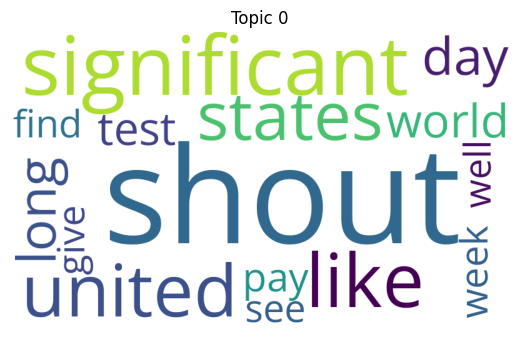

/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packag

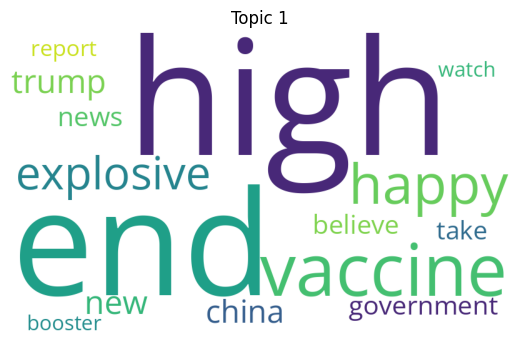

/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/wordcloud/wordcloud.py:520

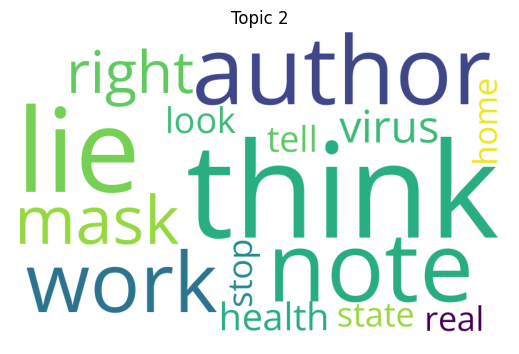

/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packag

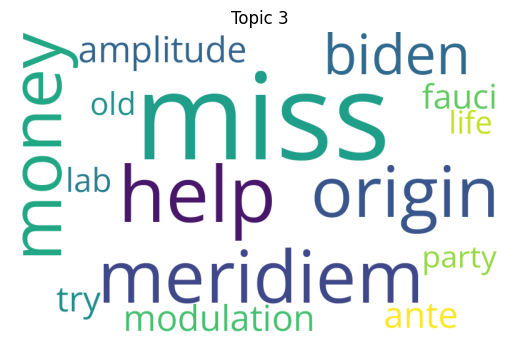

/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packag

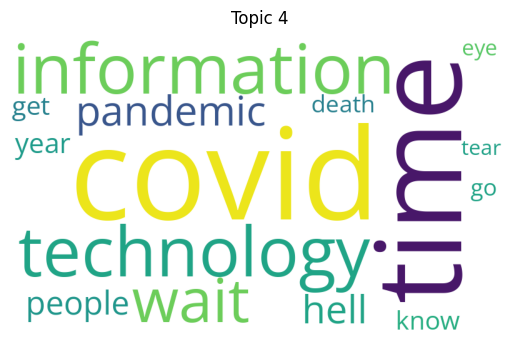

In [ ]:
# Create a dictionary of topic words and their probabilities
topics = lda_model.show_topics(num_topics=num_topics, num_words=15, formatted=False)
topic_dict = {}
for topic in topics:
    topic_dict[topic[0]] = dict(topic[1])

font_path = '../assets/fonts/OpenSans-Regular.ttf'
mask_path = '../assets/images/twitter_mask.png'
# twitter_mask = np.array(Image.open(mask_path))
# Create word clouds for each topic
for topic_id, words in topic_dict.items():
    wordcloud = WordCloud(
        width=800,
        height=500,
        font_path=font_path,
        background_color='white'
    ).generate_from_frequencies(words)
    plt.figure(figsize=(5, 5), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(f"Topic {topic_id}")
    plt.show()


#### END